In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, accuracy_score, confusion_matrix
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load datasets
train_df = pd.read_csv("/Users/zionmicwu/Desktop/train.csv")
test_df = pd.read_csv("/Users/zionmicwu/Desktop/test.csv")
test_copy = test_df.copy()

In [3]:
# Overview
print("Train Data Overview:")
print(train_df.info())
print("\nTest Data Overview:")
print(test_df.info())

print("\nTrain Data Summary:")
print(train_df.describe())

Train Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Test Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pas

In [4]:
duplicate_rows = train_df.duplicated().sum()
print(f"Number of duplicate rows in train dataset: {duplicate_rows}")
if duplicate_rows > 0:
    train_df = train_df.drop_duplicates()
    print("Duplicate rows removed from train dataset.")

Number of duplicate rows in train dataset: 0


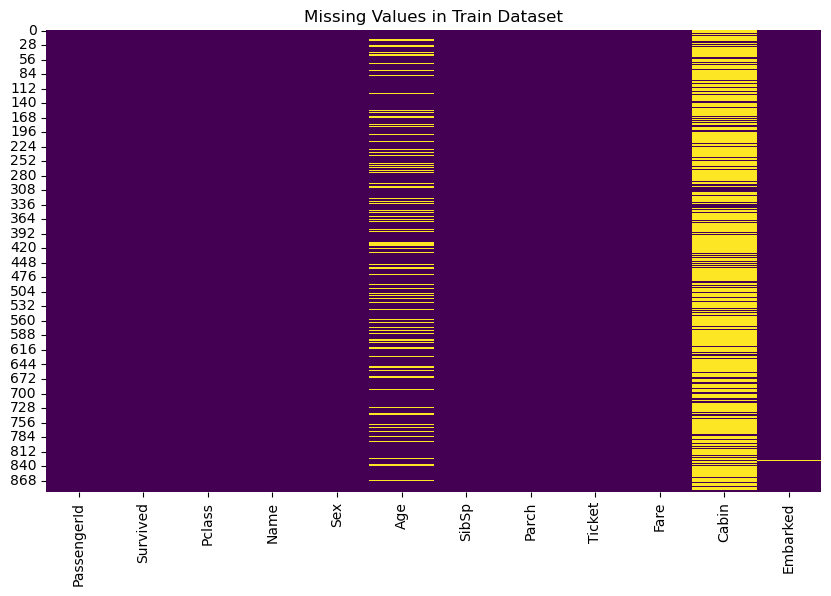

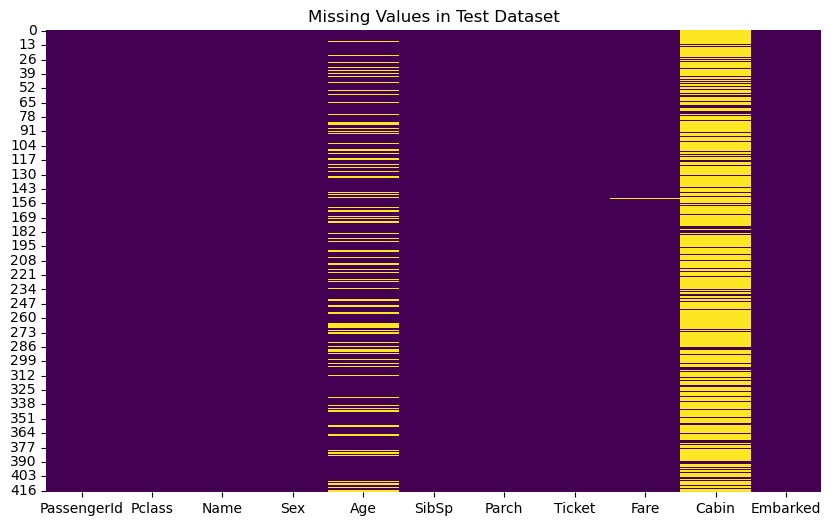

In [5]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Train Dataset")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Test Dataset")
plt.show()

In [6]:
# Handle missing values
train_df['Age'].fillna(train_df.groupby('Pclass')['Age'].transform('median'), inplace=True)
test_df['Age'].fillna(test_df.groupby('Pclass')['Age'].transform('median'), inplace=True)

train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

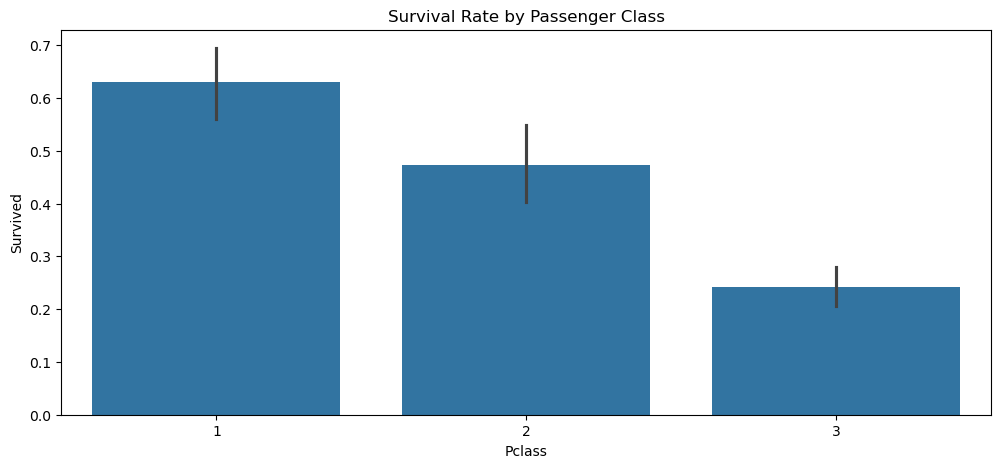

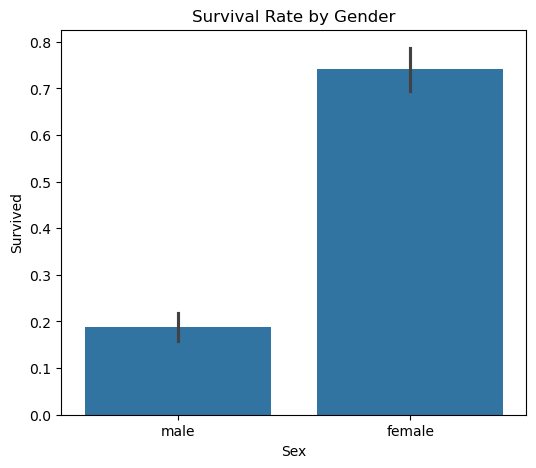

In [7]:
# Checking survival rate by class and gender
plt.figure(figsize=(12, 5))
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title("Survival Rate by Passenger Class")
plt.show()

plt.figure(figsize=(6, 5))
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title("Survival Rate by Gender")
plt.show()

In [8]:
# Convert 'Sex' column to numerical
train_df["Sex"] = train_df["Sex"].map({"male": 0, "female": 1})
test_df["Sex"] = test_df["Sex"].map({"male": 0, "female": 1})

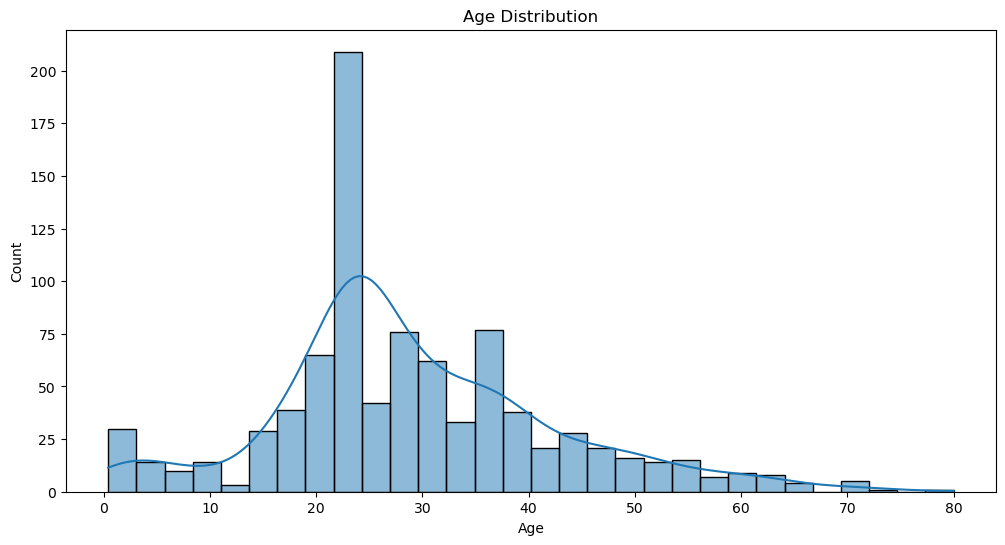

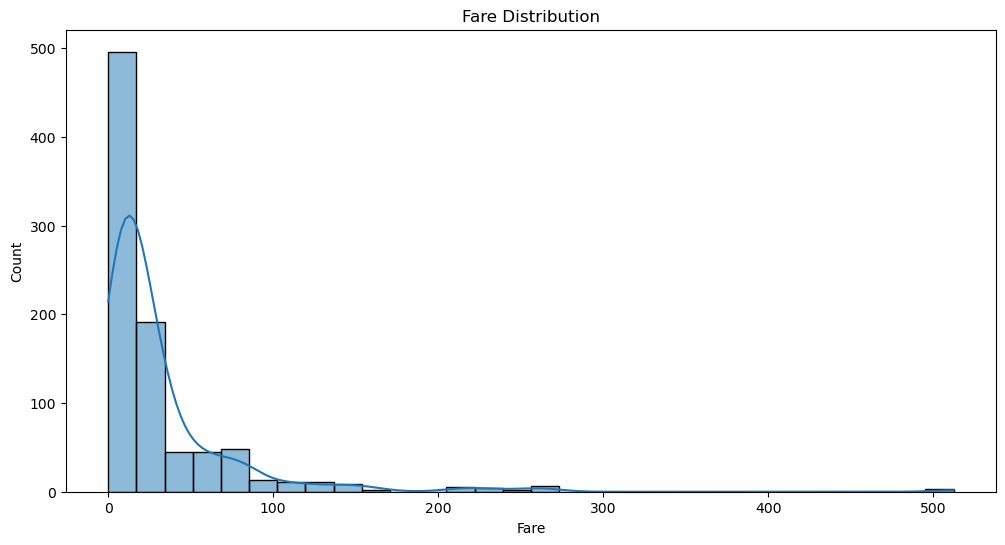

In [9]:
# Feature distributions
plt.figure(figsize=(12, 6))
sns.histplot(train_df["Age"].dropna(), kde=True, bins=30)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train_df["Fare"].dropna(), kde=True, bins=30)
plt.title("Fare Distribution")
plt.show()

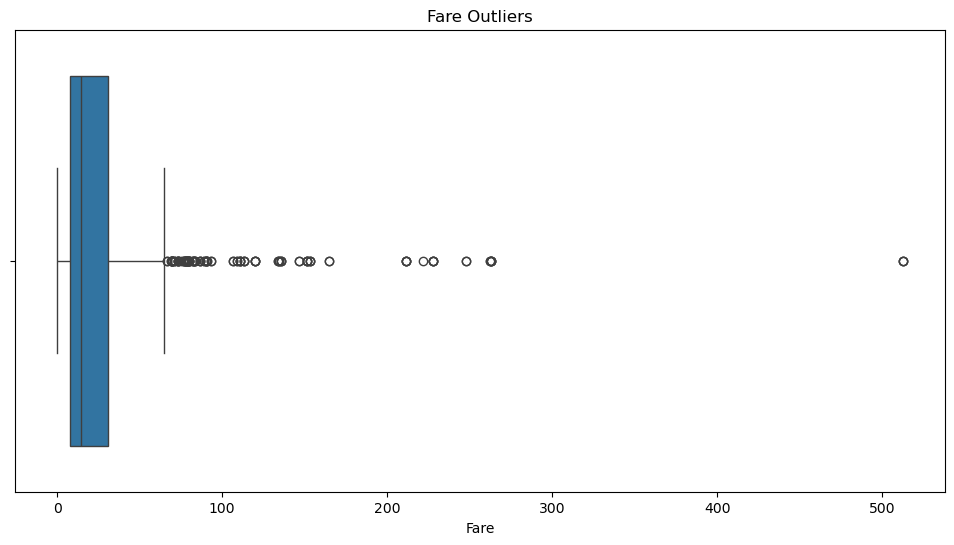

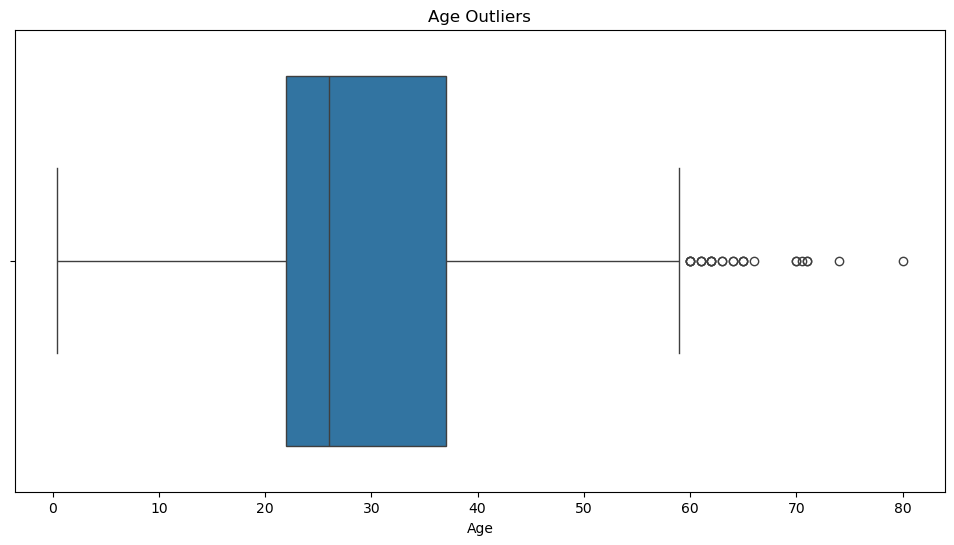

In [10]:
# Detecting Outliers using Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_df["Fare"])
plt.title("Fare Outliers")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=train_df["Age"])
plt.title("Age Outliers")
plt.show()

In [11]:
# Handling outliers
train_df = train_df[train_df['Fare'] < train_df['Fare'].quantile(0.99)]  # Removing extreme fare outliers
train_df = train_df[train_df['Age'] < train_df['Age'].quantile(0.99)]  # Removing extreme age outliers

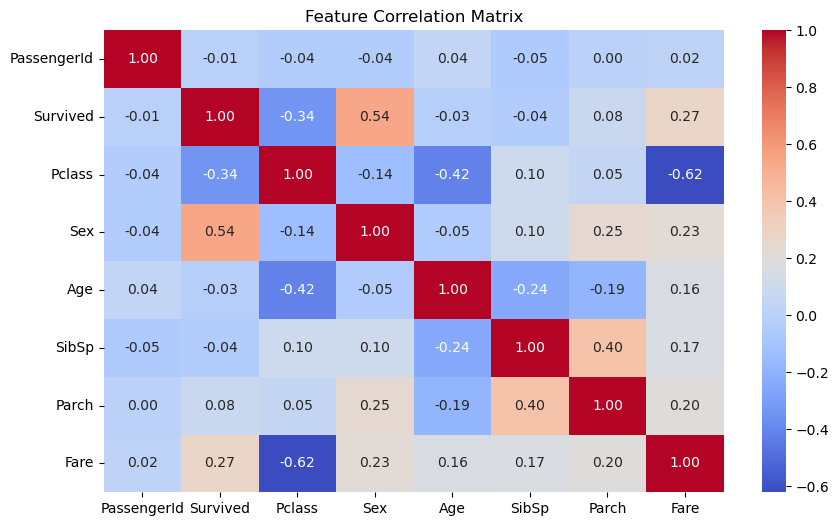

In [12]:
# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

In [13]:
# Feature Engineering
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)  # Creating IsAlone feature
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)


In [14]:
# Extract title from "Name" and categorize titles
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

train_df["Title"] = train_df["Name"].apply(extract_title)
test_df["Title"] = test_df["Name"].apply(extract_title)


def encode_title(title):
    if title in ['Mr', 'Mrs', 'Miss', 'Master']:
        return title
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title in ['Mme']:
        return 'Mrs'
    elif title in ['Dr', 'Major', 'Col', 'Capt', 'Rev']:
        return 'Officer'
    elif title in ['Don', 'Sir', 'the Countess', 'Lady', 'Jonkheer']:
        return 'Noble'
    else:
        return 'Other'

# Apply title encoding
train_df["Title"] = train_df["Title"].apply(encode_title).astype('category')
test_df["Title"] = test_df["Title"].apply(encode_title).astype('category')

# Print all unique titles found in train and test datasets
print("Unique Titles in Train Dataset:", train_df["Title"].unique())
print("Unique Titles in Test Dataset:", test_df["Title"].unique())

Unique Titles in Train Dataset: ['Mr', 'Mrs', 'Miss', 'Master', 'Noble', 'Officer', 'Other']
Categories (7, object): ['Master', 'Miss', 'Mr', 'Mrs', 'Noble', 'Officer', 'Other']
Unique Titles in Test Dataset: ['Mr', 'Mrs', 'Miss', 'Master', 'Officer', 'Other']
Categories (6, object): ['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Other']


In [15]:
# Filter categorical features
categorical_features = ["Pclass", "Embarked", "Title"]

# Prepare final datasets
X = train_df[["Sex", "Age", "Fare", "FamilySize", "IsAlone"]+categorical_features]
test = test_df[["Sex", "Age", "Fare", "FamilySize", "IsAlone"]+categorical_features]
X = pd.get_dummies(X, columns=categorical_features, drop_first=True).astype(int)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True).astype(int)
y = train_df["Survived"]

# Align train and test datasets
X, test = X.align(test, join='left', axis=1)
test.fillna(0, inplace=True)

# Standardize numerical features
scaler = StandardScaler()
X[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(X[['Age', 'Fare', 'FamilySize']])
test[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(test[['Age', 'Fare', 'FamilySize']])

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Best Parameters: {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}


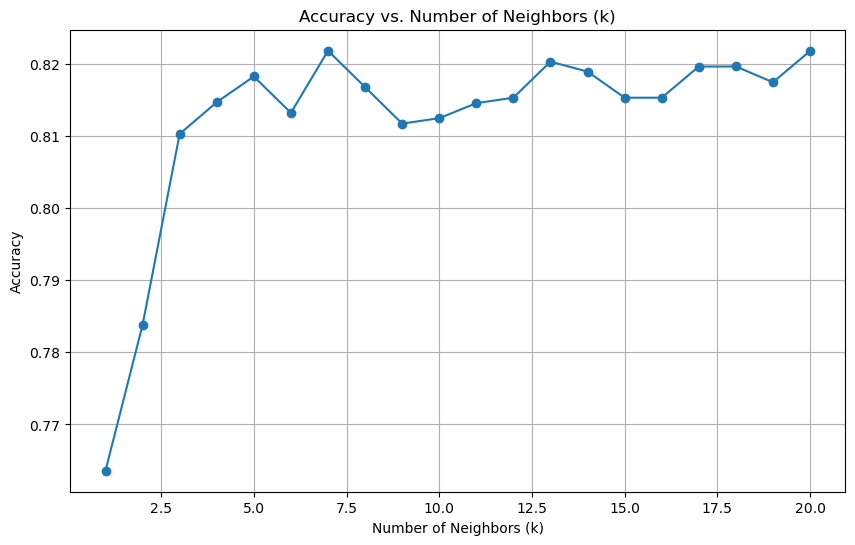

In [16]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='accuracy')
log_reg.fit(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)
log_reg_proba = log_reg.predict_proba(X_test)[:,1]

# LDA
lda = LinearDiscriminantAnalysis()
lda_scores = cross_val_score(lda, X_train, y_train, cv=cv, scoring='accuracy')
lda.fit(X_train, y_train)
lda_preds = lda.predict(X_test)
lda_proba = lda.predict_proba(X_test)[:,1]

# KNN
# Initialize base KNN model
knn = KNeighborsClassifier()

# Define hyperparameter grid
param_grid = {
    'n_neighbors': range(1, 21),  # Testing k from 1 to 20
    'weights': ['uniform', 'distance'],  # Uniform vs Distance weighting
    'p': [1, 2]  # Manhattan (p=1) vs Euclidean (p=2)
}

# Perform Grid Search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_knn = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Make predictions using the best KNN model
knn_preds = best_knn.predict(X_test)
knn_proba = best_knn.predict_proba(X_test)[:, 1]

# Visualizing Accuracy vs. k values
results = pd.DataFrame(grid_search.cv_results_)
k_values = results['param_n_neighbors'].unique()
accuracy_scores = results[results['param_weights'] == 'uniform'].groupby('param_n_neighbors')['mean_test_score'].mean()

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title("Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


----- Logistic Regression -----
              precision    recall  f1-score   support

           0       0.82      0.90      0.85       108
           1       0.80      0.67      0.73        67

    accuracy                           0.81       175
   macro avg       0.81      0.78      0.79       175
weighted avg       0.81      0.81      0.81       175



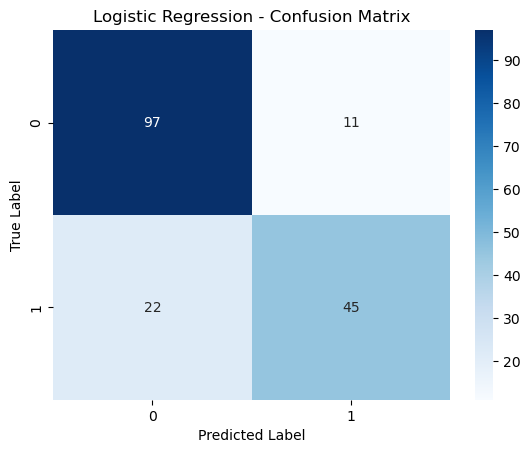


----- LDA -----
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       108
           1       0.81      0.64      0.72        67

    accuracy                           0.81       175
   macro avg       0.81      0.77      0.78       175
weighted avg       0.81      0.81      0.80       175



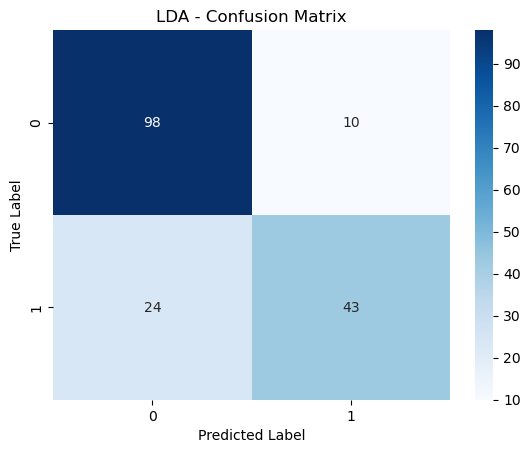


----- KNN -----
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       108
           1       0.85      0.61      0.71        67

    accuracy                           0.81       175
   macro avg       0.82      0.77      0.79       175
weighted avg       0.82      0.81      0.80       175



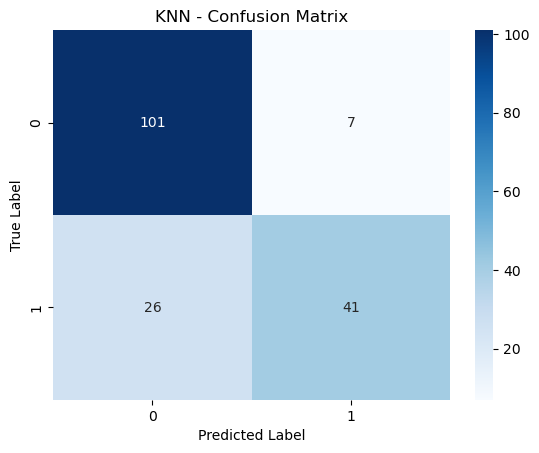

In [17]:
# Model Evaluation
models = {
    "Logistic Regression": (log_reg_preds, log_reg_proba),
    "LDA": (lda_preds, lda_proba),
    "KNN": (knn_preds, knn_proba)
}

for model_name, (preds, proba) in models.items():
    print(f"\n----- {model_name} -----")
    print(classification_report(y_test, preds))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, preds)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

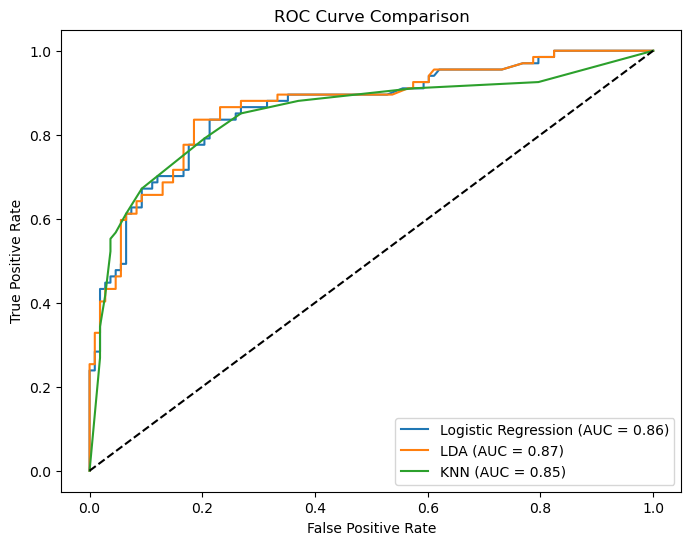

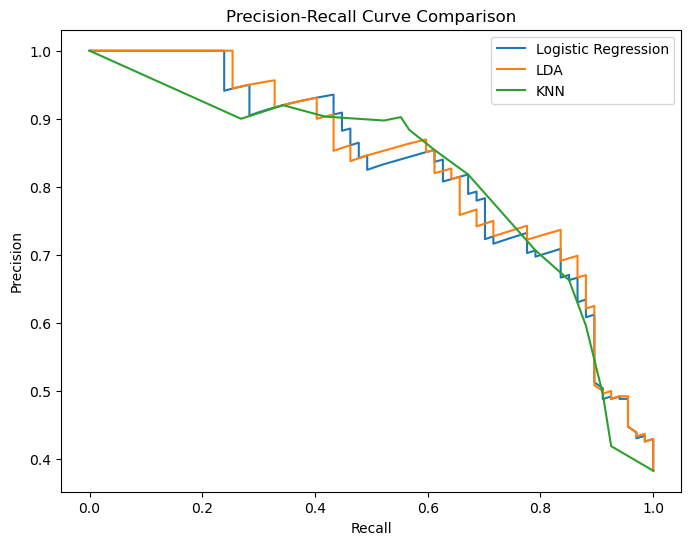

In [18]:
# ROC Curve
plt.figure(figsize=(8, 6))
for model_name, (_, proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for model_name, (_, proba) in models.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=f"{model_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()

In [19]:
# Using logistic regression for predictions
test_predictions = log_reg.predict(test)

submission = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': test_predictions})
submission.to_csv('submission_logistic.csv', index=False)

# Using lda for predictions
test_predictions = lda.predict(test)

submission = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': test_predictions})
submission.to_csv('submission_lda.csv', index=False)

# Using knn for predictions
test_predictions = best_knn.predict(test)

submission = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': test_predictions})
submission.to_csv('submission_knn.csv', index=False)